In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import math
sns.set_theme(style='darkgrid')
import pylab as pl

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
from data import get_data
from helpers import pred_to_perf

In [4]:
def fast_fracdiff(x, d):

    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T)
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    return np.real(dx[0:T])

In [5]:
def log_change(x):
    return np.log(x[-1] / x[0]) / len(x)

def pct_change(x):
    return (x[-1] - x[0]) / x[0]

In [6]:
data = pd.read_excel('data/data.xlsx', index_col=0, skiprows=[0, 1, 2, 3, 4, 5, 6, 8], sheet_name='features').astype(float)
data = data.fillna(method='ffill').shift(1).iloc[1:]
# data = data.loc[:'2020-01-01']

data['MATERIALS'] *= data['EURCHF']
data['CONSUMER STAPLE'] *= data['EURCHF']
data['INDUSTRIALS'] *= data['EURCHF']
data['CONSUMER DIS.'] *= data['EURCHF']
data['HEALTH CARE'] *= data['EURCHF']
data['FINANCIALS'] *= data['EURCHF']

data['GOLD'] *= data['USDCHF']
data['SILVER'] *= data['USDCHF']
data['BRENT'] *= data['USDCHF']
data['SP500'] *= data['USDCHF']
data['RUSSELL 2000'] *= data['USDCHF']

bench_price = data['SPI']

data = data.drop(columns=['EURCHF', 'USDCHF', 'SPI', 'SURPRISE'])

data.head()

,SMALL_MID,LARGE,MATERIALS,CONSUMER STAPLE,INDUSTRIALS,CONSUMER DIS.,HEALTH CARE,FINANCIALS,US 2YEAR,US 5YEAR,US 10YEAR,GOLD,SILVER,BRENT,SP500,RUSSELL 2000,VSMI,VIX
2006-01-05,1508.31,5833.18,276.409672,174.241453,218.695382,140.386529,175.355509,174.721116,4.304,4.277,4.344,679.214800,11.605220,78.703680,1624.934960,879.509796,13.04,11.37
2006-01-06,1509.53,5818.60,272.864640,172.733945,217.021928,139.568162,175.452705,173.846165,4.321,4.284,4.354,672.828960,11.181886,78.075236,1626.488656,883.552911,13.22,11.31
2006-01-09,1516.33,5828.32,274.390587,173.003134,217.791843,140.132384,175.331222,174.622003,4.354,4.316,4.375,685.399920,11.463555,79.666944,1632.778590,888.382961,13.10,11.00
2006-01-10,1518.68,5823.36,274.741194,172.954918,217.963610,140.964506,175.453688,175.052650,4.345,4.302,4.367,699.485820,11.715558,79.180569,1647.392535,901.822117,13.53,11.13
2006-01-11,1512.24,5785.15,271.683725,173.365830,217.371702,140.438683,174.153856,173.844827,4.395,4.358,4.426,694.241856,11.468668,79.300944,1651.705983,910.590507,14.18,10.86


In [7]:
target_prices = data[['SMALL_MID', 'LARGE']]
target_prices.tail()

,SMALL_MID,LARGE
2021-12-21,5887.48,15267.75
2021-12-22,5929.83,15370.42
2021-12-23,6011.07,15409.96
2021-12-24,6063.28,15487.32
2021-12-27,6063.28,15487.32


# TARGET

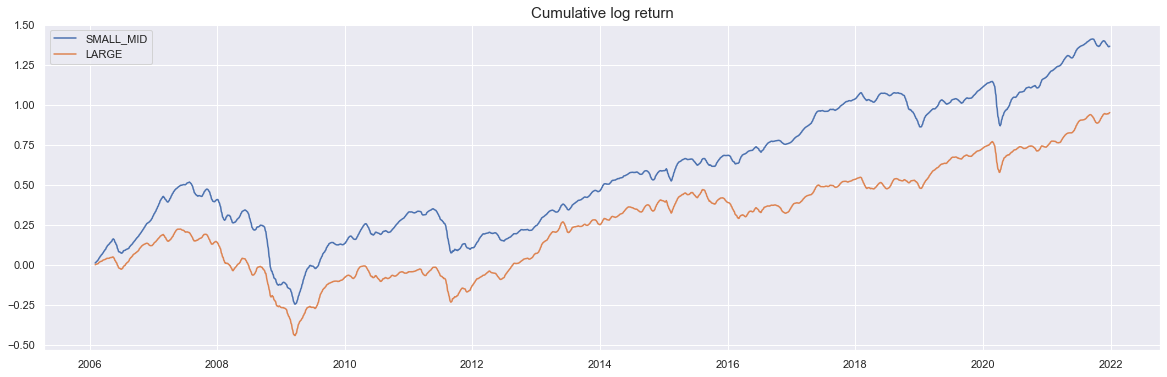

In [8]:
fig, ax = plt.subplots(figsize=(20, 6))
data_plot = np.log((target_prices.pct_change() + 1).cumprod().rolling(20).mean())
sns.lineplot(data=data_plot, dashes=False)
plt.title('Cumulative log return', fontsize=15)
plt.show()

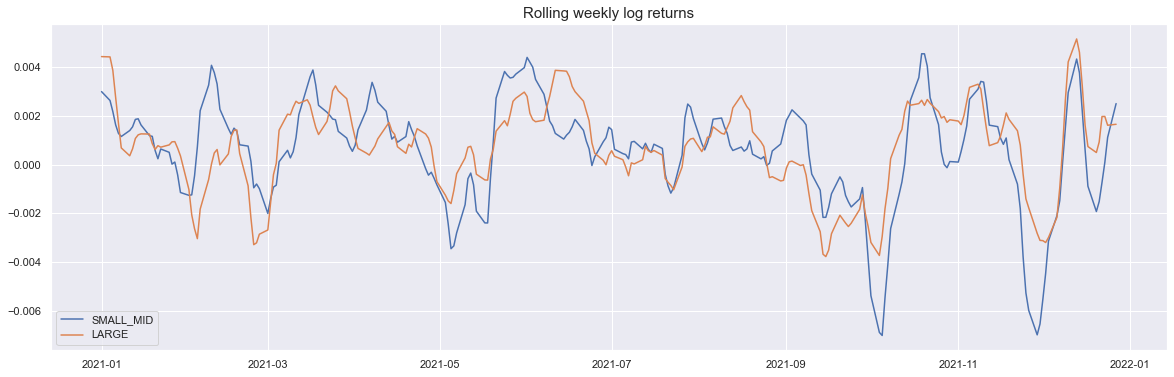

In [9]:
fig, ax = plt.subplots(figsize=(20, 6))
data_plot = target_prices.rolling(5).apply(lambda x: log_change(x)).rolling(5).mean()
sns.lineplot(data=data_plot.loc['2021-01-01':], dashes=False)
plt.title('Rolling weekly log returns', fontsize=15)
plt.show()

In [10]:
benchmark_portfolio = pd.read_excel('data/spiex_spi20_weights.xlsx', index_col=0)
benchmark_portfolio = benchmark_portfolio.rename(columns={'SPIEX':'SMALL_MID', 'SPI20': 'LARGE'})
benchmark_portfolio = benchmark_portfolio[['SMALL_MID', 'LARGE']].reindex(target_prices.index, method='bfill')
SMALL_portfolio = benchmark_portfolio + [0.15, -0.15]
LARGE_portfolio = benchmark_portfolio + [-0.15, 0.15]

In [11]:
target_monthy_returns = target_prices.rolling(21).apply(lambda x: pct_change(x))
bench_monthly_returns = (benchmark_portfolio * target_monthy_returns).sum(axis=1)
spi_monthly_returns = bench_price.rolling(21).apply(lambda x: pct_change(x))
SMALL_monthly_returns = (SMALL_portfolio * target_monthy_returns).sum(axis=1)
LARGE_monthly_returns = (LARGE_portfolio * target_monthy_returns).sum(axis=1)

SMALL_excess_returns = SMALL_monthly_returns - bench_monthly_returns
LARGE_excess_returns = LARGE_monthly_returns - bench_monthly_returns

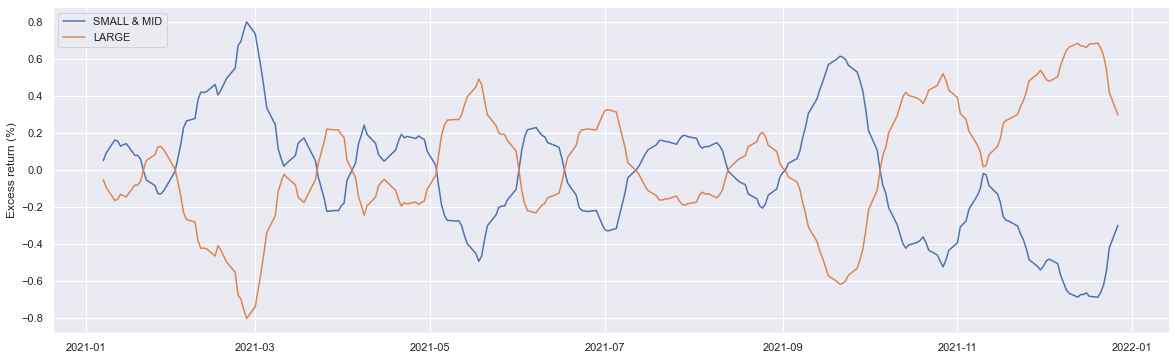

In [12]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(SMALL_excess_returns.loc['2021-01-01':].rolling(5).mean() * 100, label='SMALL & MID')
plt.plot(LARGE_excess_returns.loc['2021-01-01':].rolling(5).mean() * 100, label='LARGE')
plt.legend()
plt.ylabel('Excess return (%)')
plt.savefig('plots/latex/rolling_excess.png', dpi=300, bbox_inches='tight')
plt.show()

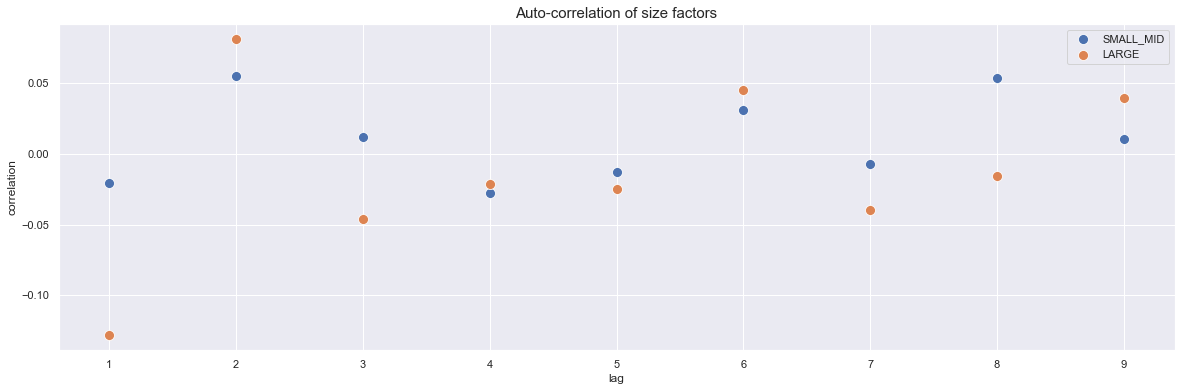

In [13]:
week_input_period = 10
auto_corr = {}
fig, ax = plt.subplots(figsize=(20, 6))
weekly_returns = target_prices.resample('W').apply(lambda x: log_change(x))
for size in weekly_returns.columns:
    auto_corr[size] = []
    for l in range(1, week_input_period):
        auto_corr[size].append(weekly_returns[size].corr(weekly_returns[size].shift(-l)))
    sns.scatterplot(x=range(1, week_input_period), y=auto_corr[size], label=size, s=100)
plt.xticks(range(1, week_input_period))
plt.title('Auto-correlation of size factors', fontsize=15)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

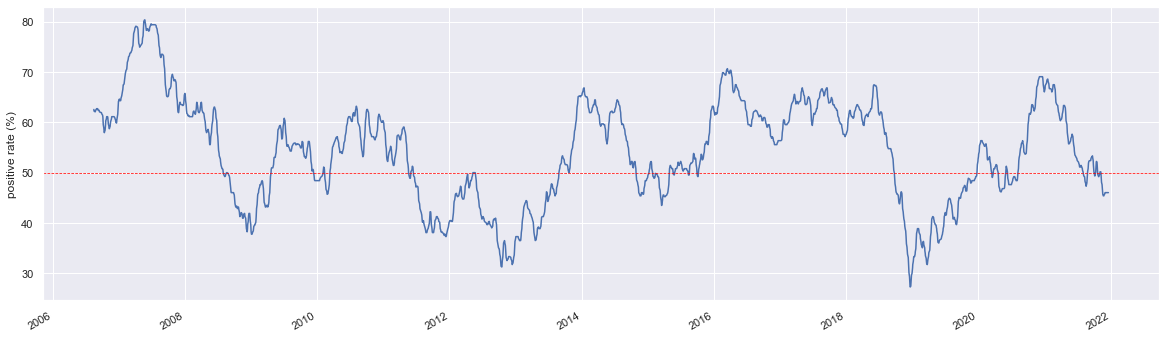

In [17]:
neutral_threshold = 0.0005
daily_forward_weekly_returns = target_prices.rolling(5).apply(lambda x: log_change(x)).shift(-5).dropna()
daily_forward_weekly_returns['abs_diff'] = np.abs(daily_forward_weekly_returns.SMALL_MID - daily_forward_weekly_returns.LARGE)
daily_forward_weekly_returns['positive'] = (daily_forward_weekly_returns.SMALL_MID > daily_forward_weekly_returns.LARGE).astype(int)
daily_forward_weekly_returns = daily_forward_weekly_returns[daily_forward_weekly_returns.abs_diff > neutral_threshold]

daily_forward_weekly_returns['positive_rate'] = 100 * daily_forward_weekly_returns.positive.rolling(126).apply(lambda x: np.count_nonzero(x == 1) / len(x))
daily_forward_weekly_returns = daily_forward_weekly_returns.dropna()

fig, ax = plt.subplots(figsize=(20, 6))
daily_forward_weekly_returns.positive_rate.rolling(5).mean().plot(ax=ax)
plt.ylabel('positive rate (%)')
ax.axhline(y=50, linestyle='--', color='red', lw=0.75)
plt.savefig('plots/latex/rolling_rate.png', dpi=300, bbox_inches='tight')
plt.show()

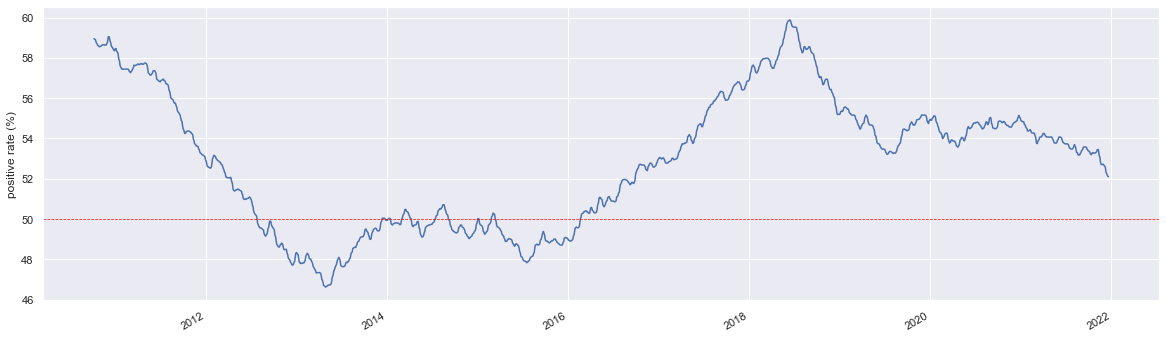

In [18]:
neutral_threshold = 0.0005
daily_forward_weekly_returns = target_prices.rolling(5).apply(lambda x: log_change(x)).shift(-5).dropna()
daily_forward_weekly_returns['abs_diff'] = np.abs(daily_forward_weekly_returns.SMALL_MID - daily_forward_weekly_returns.LARGE)
daily_forward_weekly_returns['positive'] = (daily_forward_weekly_returns.SMALL_MID > daily_forward_weekly_returns.LARGE).astype(int)
daily_forward_weekly_returns = daily_forward_weekly_returns[daily_forward_weekly_returns.abs_diff > neutral_threshold]

daily_forward_weekly_returns['positive_rate'] = 100 * daily_forward_weekly_returns.positive.rolling(252 * 4).apply(lambda x: np.count_nonzero(x == 1) / len(x))
daily_forward_weekly_returns = daily_forward_weekly_returns.dropna()

fig, ax = plt.subplots(figsize=(20, 6))
daily_forward_weekly_returns.positive_rate.rolling(5).mean().plot(ax=ax)
plt.ylabel('positive rate (%)')
ax.axhline(y=50, linestyle='--', color='red', lw=0.75)
plt.savefig('plots/latex/rolling_rate_4Y.png', dpi=300, bbox_inches='tight')
plt.show()

# FEATURES

In [15]:
technical_features = data[['SMALL_MID', 'LARGE']]

mom5 = technical_features.rolling(5).apply(lambda x: log_change(x))
mom5 = mom5.add_suffix(' mom5')

mom21 = technical_features.rolling(21).apply(lambda x: log_change(x))
mom21 = mom21.add_suffix(' mom21')

mom63 = technical_features.rolling(63).apply(lambda x: log_change(x))
mom63 = mom63.add_suffix(' mom63')

vol21 = technical_features.rolling(5).apply(lambda x: log_change(x)).rolling(21).std()
vol21 = vol21.add_suffix(' vol21')

skew21 = technical_features.rolling(5).apply(lambda x: log_change(x)).rolling(21).skew()
skew21 = skew21.add_suffix(' skew21')

corr = target_prices.SMALL_MID.rolling(5).apply(lambda x: log_change(x)).rolling(21).corr(target_prices.LARGE.rolling(5).apply(lambda x: log_change(x))).rename('correlation')

features = pd.DataFrame(index=technical_features.index)
for feature in (set(data.columns) - set(technical_features)):
    #features[feature] = fast_fracdiff(data[feature], 0.5)
    features[feature] = data[feature].rolling(5).apply(lambda x: log_change(x))

features = pd.concat([mom5, mom21, mom63, vol21, skew21, corr, features], axis=1).ewm(5).mean().dropna()

features.head(5)

,SMALL_MID mom5,LARGE mom5,SMALL_MID mom21,LARGE mom21,SMALL_MID mom63,LARGE mom63,SMALL_MID vol21,LARGE vol21,SMALL_MID skew21,LARGE skew21,correlation,GOLD,SILVER,US 5YEAR,BRENT,HEALTH CARE,RUSSELL 2000,US 10YEAR,CONSUMER DIS.,SP500,CONSUMER STAPLE,FINANCIALS,MATERIALS,INDUSTRIALS,US 2YEAR
2006-04-03,0.001734,-0.000138,0.001987,0.000582,0.001972,0.000648,0.001889,0.002158,-0.967936,0.641191,0.339509,0.003677,0.007500,0.002804,0.004831,-0.000045,0.002206,0.002904,0.000693,-0.000306,-0.000726,0.000012,0.002142,0.001047,0.002220
2006-04-04,0.001879,0.000316,0.002005,0.000638,0.002031,0.000723,0.001895,0.002154,-0.938578,0.640904,0.347240,0.004428,0.009026,0.002669,0.005074,0.000287,0.002292,0.002987,0.000980,-0.000034,-0.000390,0.000644,0.002988,0.001774,0.002203
2006-04-05,0.002176,0.000543,0.002121,0.000708,0.002041,0.000715,0.001907,0.002151,-0.910757,0.637757,0.354832,0.004309,0.009227,0.002363,0.004168,0.000160,0.001344,0.002903,0.000936,-0.000435,-0.000256,0.000875,0.003563,0.002144,0.001960
2006-04-06,0.002428,0.000679,0.002302,0.000829,0.002060,0.000741,0.001915,0.002135,-0.924143,0.623099,0.355066,0.003512,0.008279,0.001699,0.003403,-0.000080,0.000890,0.002336,0.000755,-0.000464,-0.000380,0.000808,0.003521,0.002026,0.001412
2006-04-07,0.002594,0.000873,0.002454,0.000916,0.002100,0.000792,0.001887,0.002113,-0.966695,0.589475,0.344033,0.003212,0.007813,0.001589,0.003438,-0.000235,0.000429,0.002303,0.000671,-0.000382,-0.000522,0.000878,0.003883,0.001985,0.001301


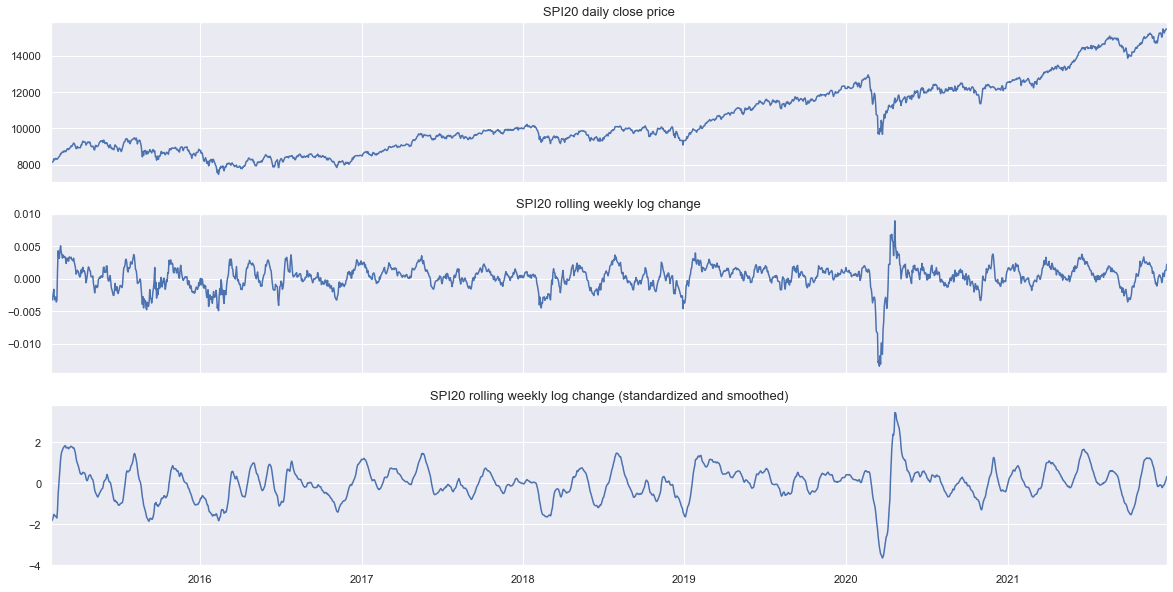

In [75]:
from sklearn.preprocessing import PowerTransformer

fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

large = data.LARGE.loc['2015-01-01':]
large.plot(ax=axs[0])
axs[0].set_title('SPI20 daily close price', fontsize=13)

large_mom21 = large.rolling(21).apply(lambda x: log_change(x)).dropna()
large_mom21.plot(ax=axs[1])
axs[1].set_title('SPI20 rolling weekly log change', fontsize=13)

large_mom21_transformed = PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(large_mom21.values.reshape(-1, 1))
large_mom21_transformed = pd.Series(index=large_mom21.index, data=large_mom21_transformed.reshape(-1))
large_mom21_transformed.ewm(5).mean().plot(ax=axs[2])
axs[2].set_title('SPI20 rolling weekly log change (standardized and smoothed)', fontsize=13)

plt.savefig('plots/latex/large_mom21_preprocess.png', dpi=300, bbox_inches='tight')
plt.show()

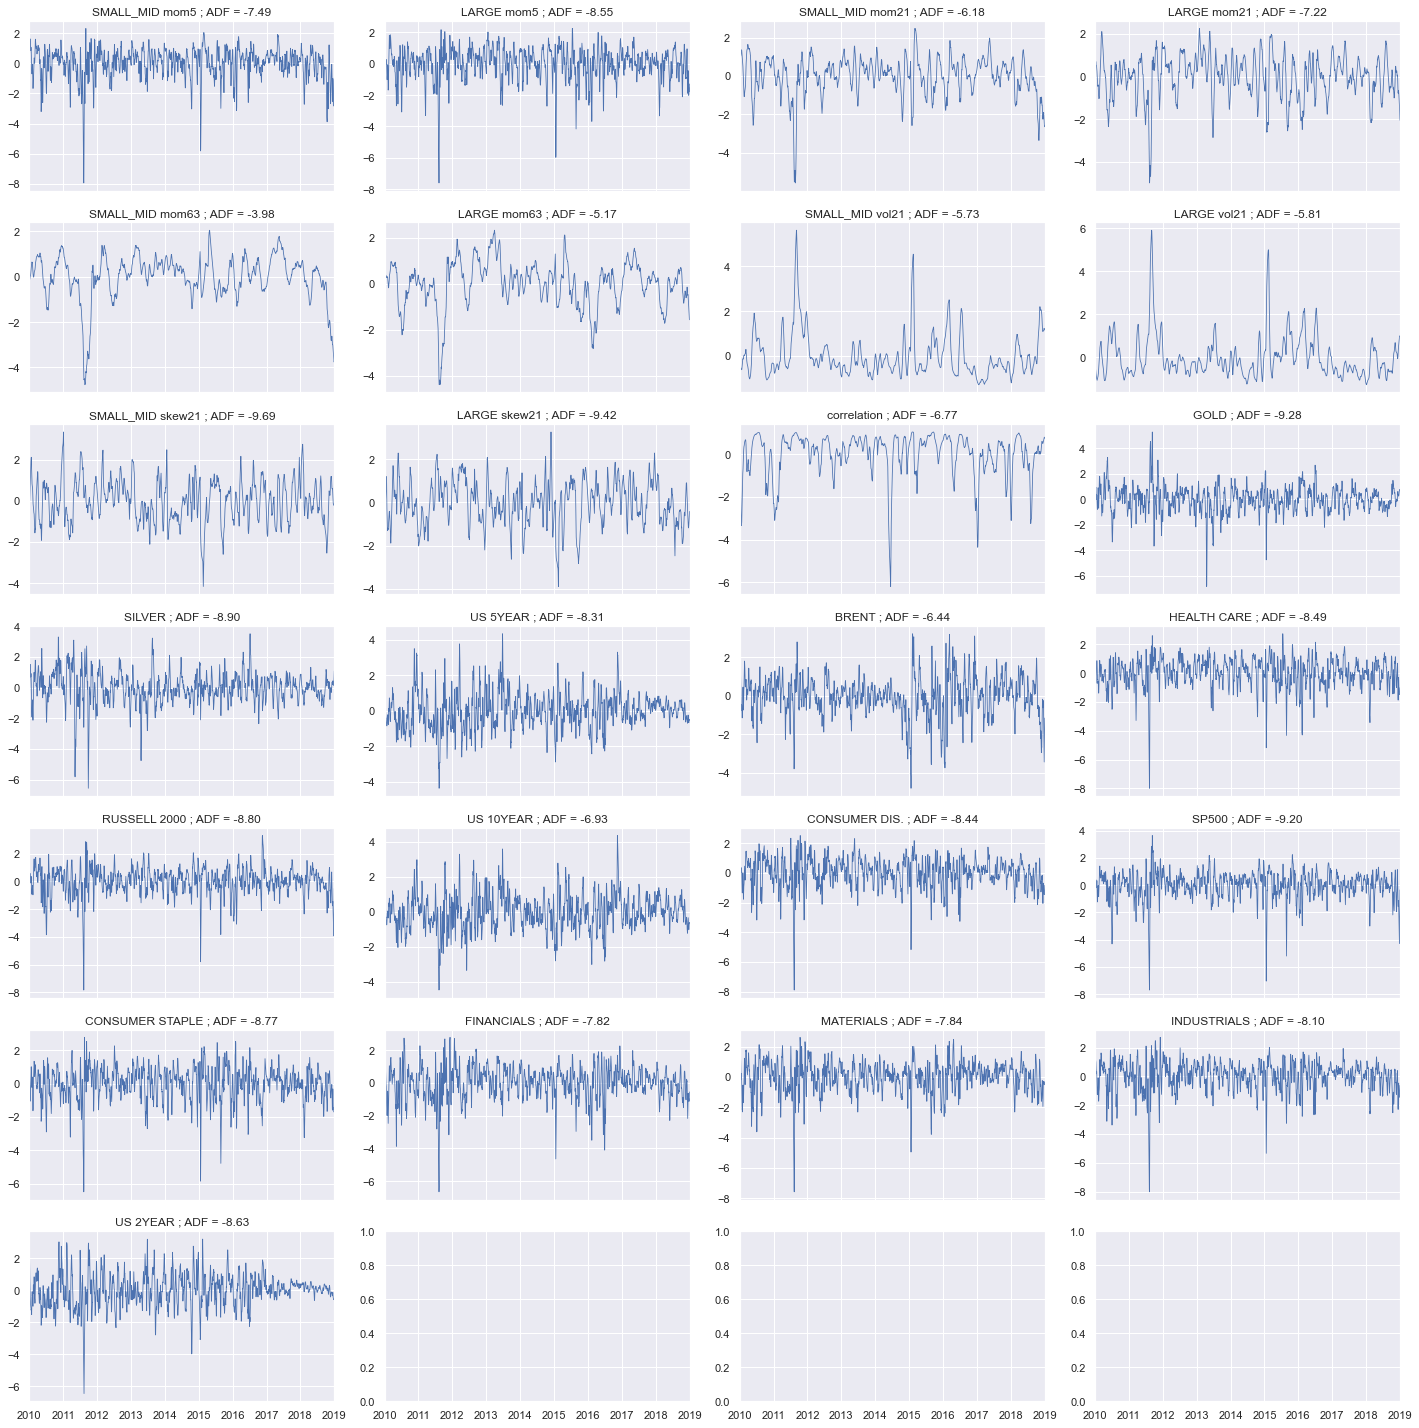

In [16]:
data_plot = features.loc['2010-01-01':'2019-01-01']
data_plot = (data_plot - data_plot.mean()) / data_plot.std()

number_feature = len(data_plot.columns)
fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(20, 20), sharex=True)
axs = axs.ravel()

for i, col in enumerate(data_plot.columns):
    
    ads = adfuller(data_plot[col].values)[0]
    data_plot[col].plot(ax=axs[i], lw=0.8)
    axs[i].set_title(col + f' ; ADF = {ads:.2f}')

# plt.suptitle('Time series features after normalization (train set)', fontsize=15, fontweight='bold')
fig.tight_layout()
# fig.subplots_adjust(top=0.97)
plt.show()

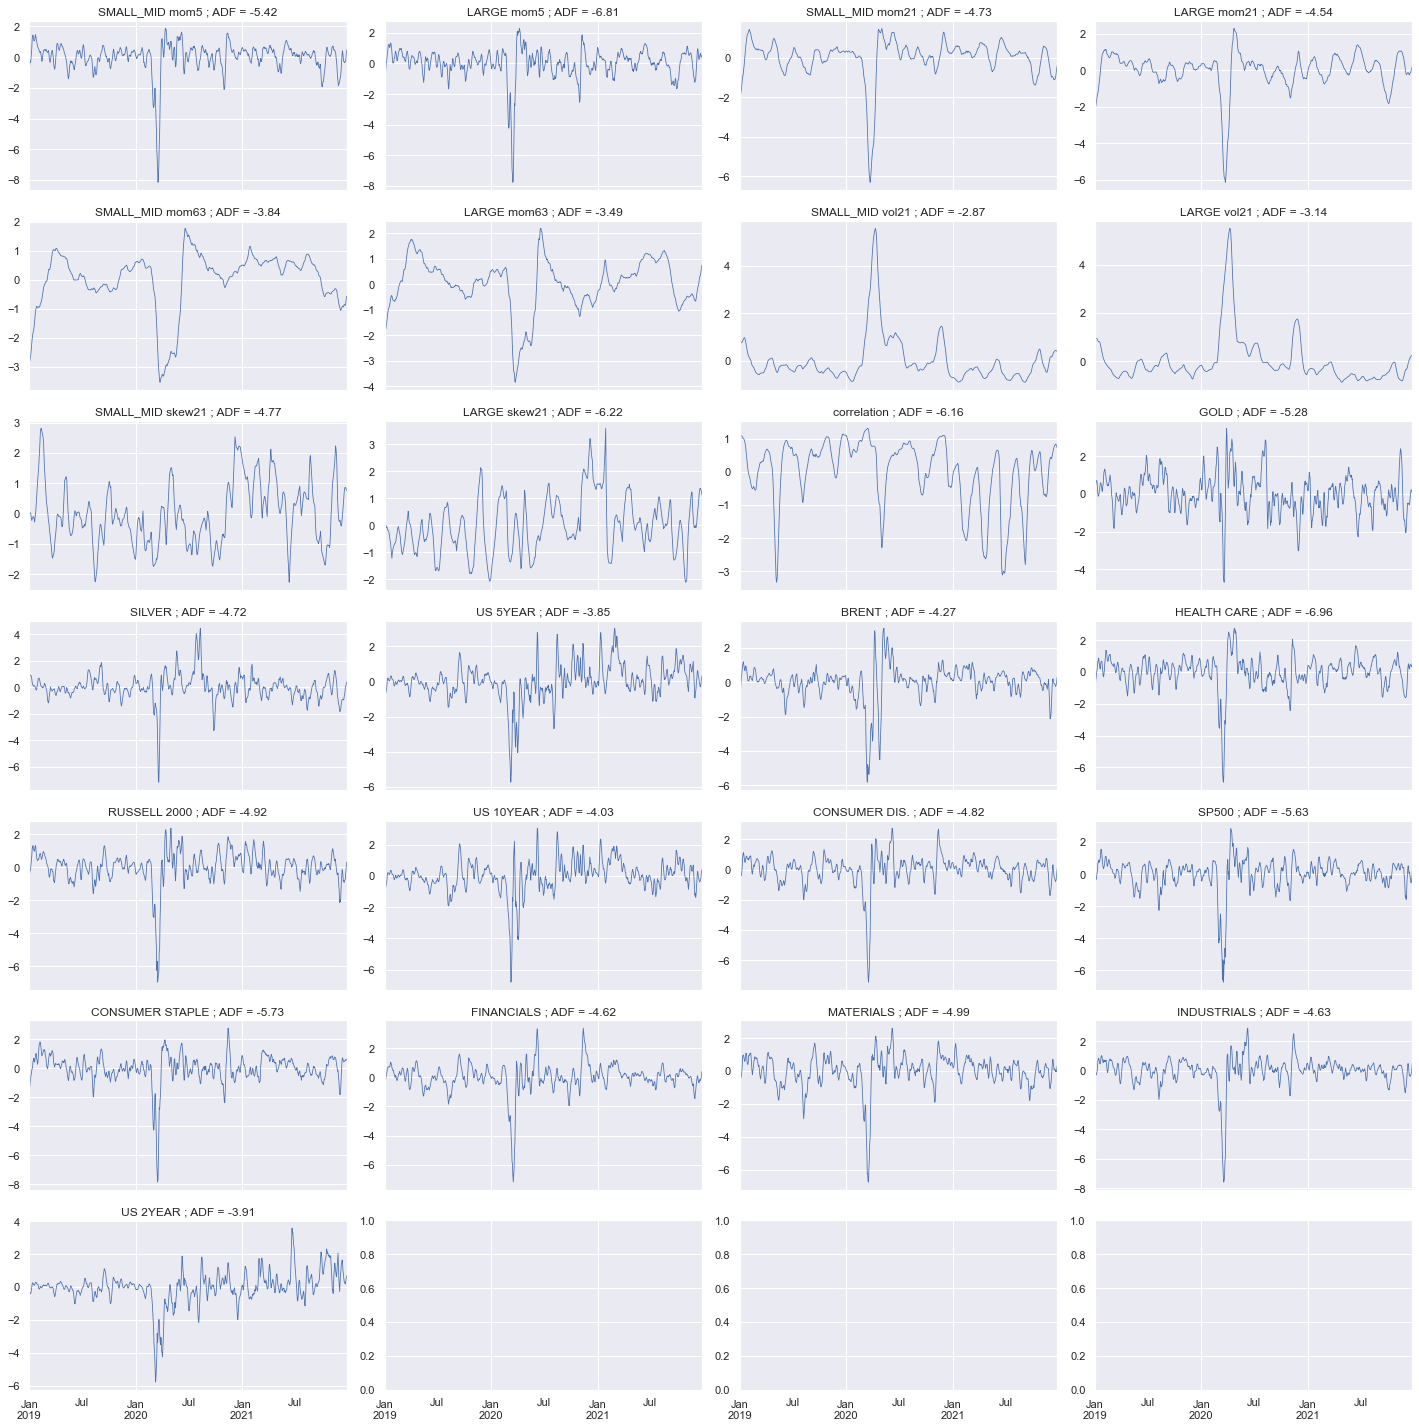

In [17]:
data_plot = features.loc['2019-01-01':]
data_plot = (data_plot - data_plot.mean()) / data_plot.std()

number_feature = len(data_plot.columns)
fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(20, 20), sharex=True)
axs = axs.ravel()

for i, col in enumerate(data_plot.columns):
    
    ads = adfuller(data_plot[col].values)[0]
    data_plot[col].plot(ax=axs[i], lw=0.8)
    axs[i].set_title(col + f' ; ADF = {ads:.2f}')

# plt.suptitle('Time series features after normalization (test set)', fontsize=15, fontweight='bold')
fig.tight_layout()
# fig.subplots_adjust(top=0.97)
plt.show()

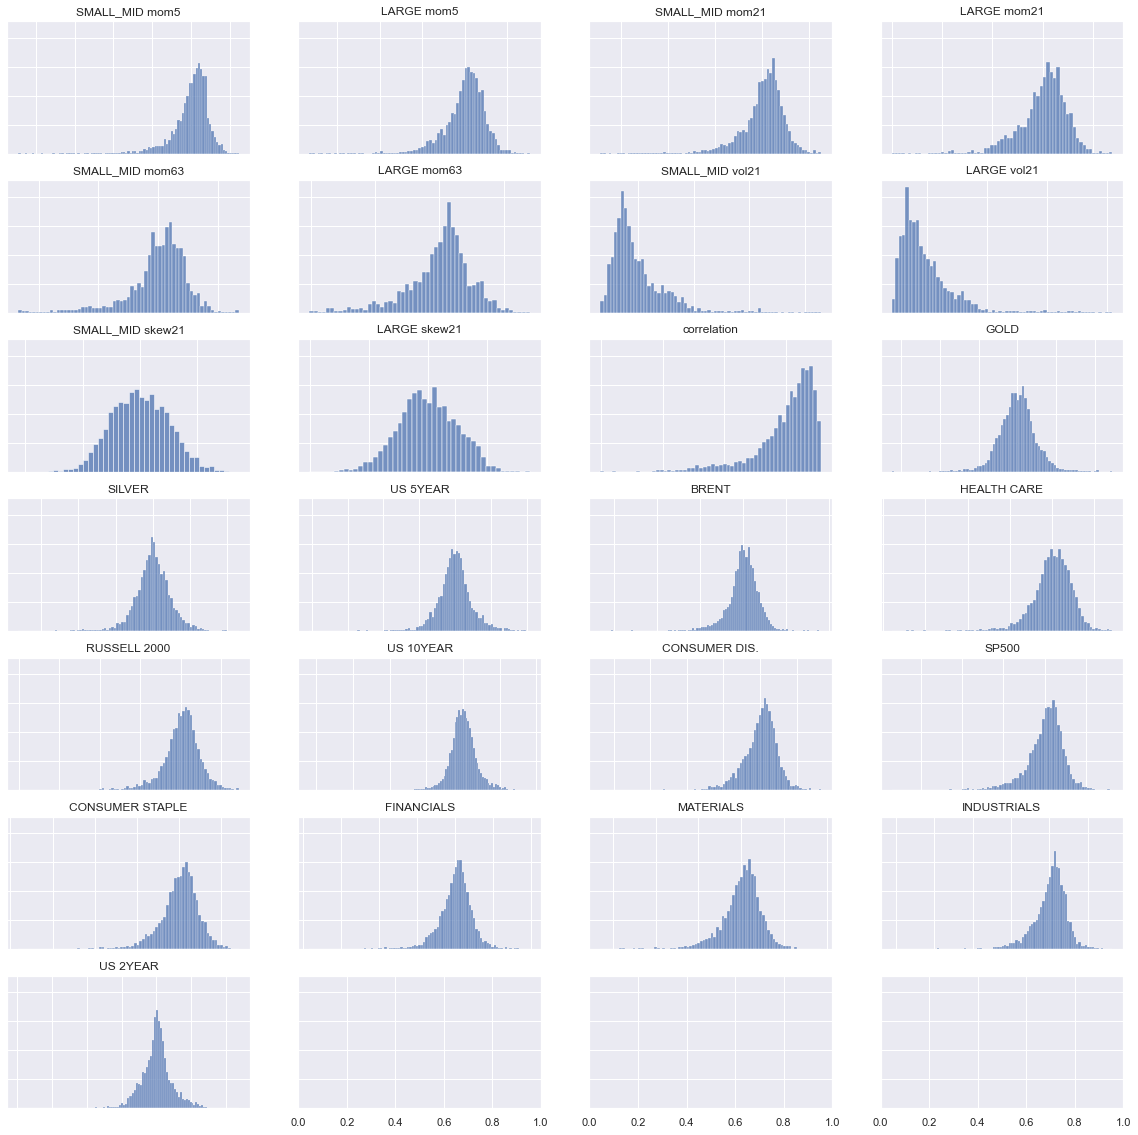

In [18]:
fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(20, 20), sharey=True)
axs = axs.ravel()
for i, feature in enumerate(features):
    data = features[feature]
    data = (data - data.mean()) / data.std()
    sns.histplot(ax=axs[i], data=data)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(which='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature)

# FEATURES VS TARGET

In [19]:
daily_forward_weekly_returns = target_prices.rolling(5).apply(lambda x: log_change(x)).shift(-5).reindex(features.index)

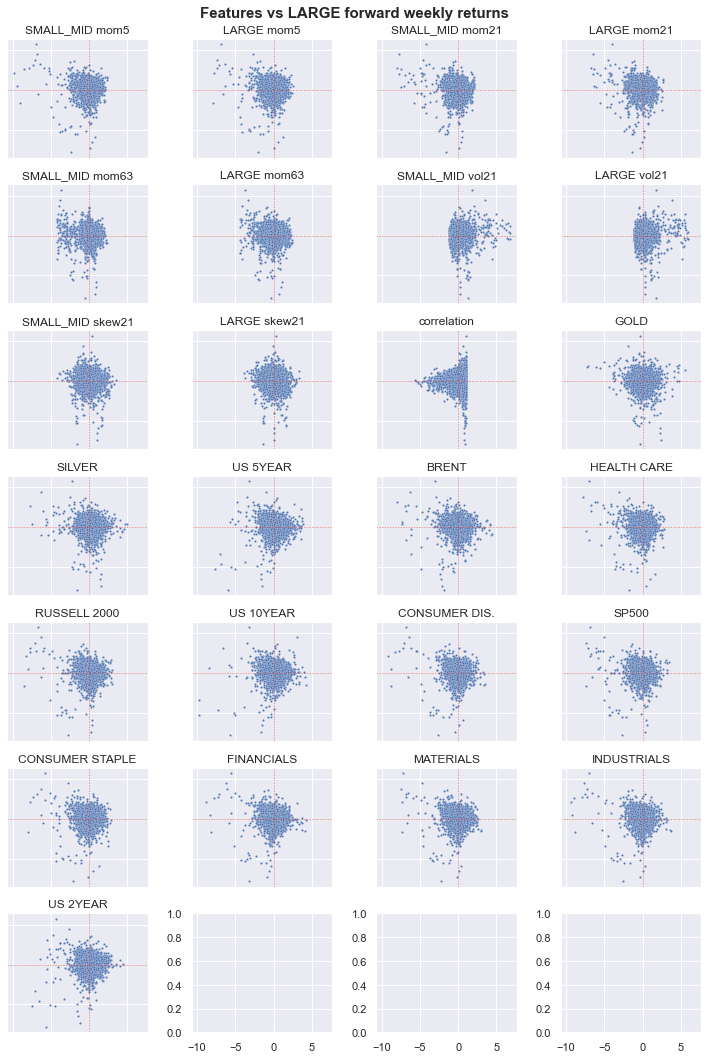

In [20]:
data_plot = features.loc['2011-01-01':]
data_plot = (data_plot - data_plot.mean()) / data_plot.std()

number_feature = len(data_plot.columns)
fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(10, 15), sharex=True)
axs = axs.ravel()

for i, col in enumerate(data_plot.columns):
    
    sns.scatterplot(ax=axs[i], x=data_plot[col], 
                    y=daily_forward_weekly_returns.LARGE.reindex(data_plot.index), legend=False, s=5)
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.5)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.5)
    
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(col)

plt.suptitle('Features vs LARGE forward weekly returns', fontsize=15, fontweight='bold')
fig.tight_layout()
#fig.subplots_adjust(top=0.97)
plt.show()

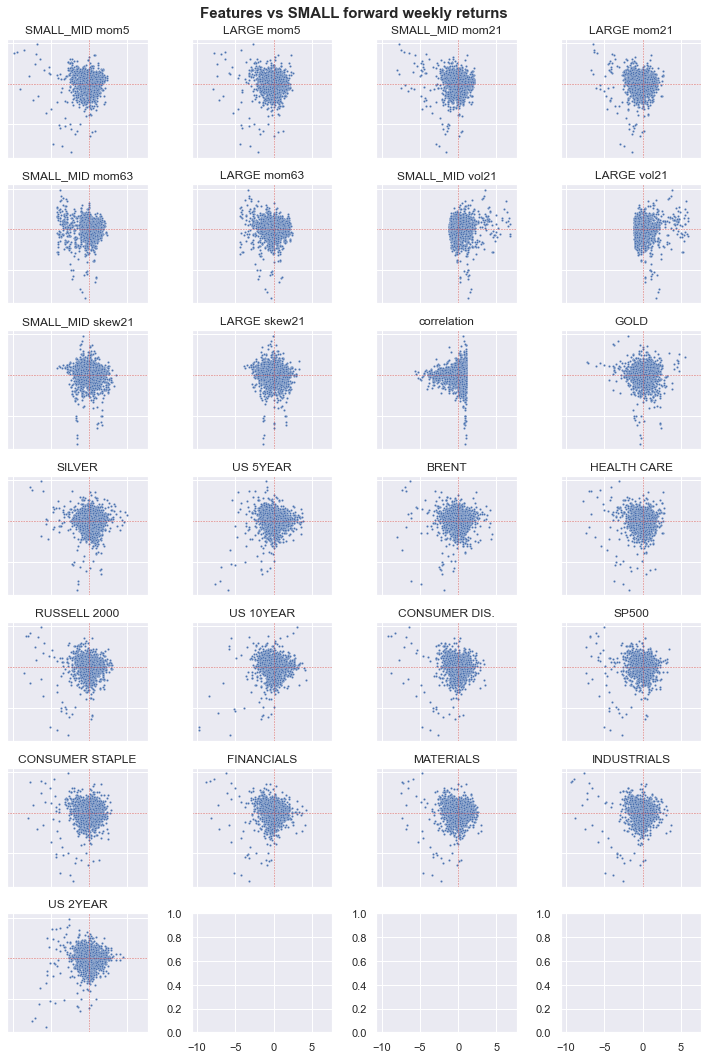

In [21]:
data_plot = features.loc['2011-01-01':]
data_plot = (data_plot - data_plot.mean()) / data_plot.std()

number_feature = len(data_plot.columns)
fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(10, 15), sharex=True)
axs = axs.ravel()

for i, col in enumerate(data_plot.columns):
    
    sns.scatterplot(ax=axs[i], x=data_plot[col], 
                    y=daily_forward_weekly_returns.SMALL_MID.reindex(data_plot.index), legend=False, s=5)
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.5)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.5)
    
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(col)

plt.suptitle('Features vs SMALL forward weekly returns', fontsize=15, fontweight='bold')
fig.tight_layout()
#fig.subplots_adjust(top=0.97)
plt.show()

In [22]:
df_features_beta = pd.DataFrame(index=target_prices.columns, columns=features.columns)
df_features_stat = pd.DataFrame(index=target_prices.columns, columns=features.columns)

for feature in features:
    for target in daily_forward_weekly_returns:
        
        X = features[feature].iloc[:-5].dropna()
        y = daily_forward_weekly_returns[target].reindex(X.index)
        # X = sm.add_constant(X)
        model = sm.OLS(y, X, missing='raise')
        results = model.fit()
        
        df_features_stat.at[target, feature] = results.pvalues.values
        df_features_stat = df_features_stat.astype(float)
        
        df_features_beta.at[target, feature] = results.params.values
        df_features_beta = df_features_stat.astype(float)
        
print('Beta')
display(df_features_beta[np.abs(df_features_beta) > 0.01].round(4))
print('P-value')
display(df_features_stat[df_features_stat < 0.05].round(4))

Beta


,SMALL_MID mom5,LARGE mom5,SMALL_MID mom21,LARGE mom21,SMALL_MID mom63,LARGE mom63,SMALL_MID vol21,LARGE vol21,SMALL_MID skew21,LARGE skew21,correlation,GOLD,SILVER,US 5YEAR,BRENT,HEALTH CARE,RUSSELL 2000,US 10YEAR,CONSUMER DIS.,SP500,CONSUMER STAPLE,FINANCIALS,MATERIALS,INDUSTRIALS,US 2YEAR
SMALL_MID,0.3902,0.3895,0.2195,NaN,0.2107,0.9879,NaN,NaN,NaN,0.1597,NaN,NaN,NaN,0.0197,0.5528,0.1395,0.3951,NaN,0.4772,0.1387,0.0471,0.6057,0.1979,0.7072,NaN
LARGE,NaN,NaN,NaN,0.0201,0.5540,0.1362,NaN,NaN,0.0241,NaN,NaN,NaN,NaN,0.4403,NaN,NaN,NaN,0.5392,NaN,NaN,NaN,NaN,NaN,NaN,0.9451


P-value


,SMALL_MID mom5,LARGE mom5,SMALL_MID mom21,LARGE mom21,SMALL_MID mom63,LARGE mom63,SMALL_MID vol21,LARGE vol21,SMALL_MID skew21,LARGE skew21,correlation,GOLD,SILVER,US 5YEAR,BRENT,HEALTH CARE,RUSSELL 2000,US 10YEAR,CONSUMER DIS.,SP500,CONSUMER STAPLE,FINANCIALS,MATERIALS,INDUSTRIALS,US 2YEAR
SMALL_MID,NaN,NaN,NaN,0.0062,NaN,NaN,0.0003,0.0003,0.0056,NaN,0.0004,0.0,0.0,0.0197,NaN,NaN,NaN,0.0036,NaN,NaN,0.0471,NaN,NaN,NaN,0.0069
LARGE,0.0001,0.0,0.001,0.0201,NaN,NaN,0.0007,0.0041,0.0241,0.0041,0.0050,0.0,0.0,NaN,0.01,0.0,0.0,NaN,0.0004,0.0,0.0006,0.0014,0.0001,0.0,NaN


In [23]:
df_features_corr = pd.DataFrame(index=target_prices.columns)

for col in features.columns:
    df_features_corr[col] = daily_forward_weekly_returns.corrwith(features[col])
display(df_features_corr.round(4) * 100)

,SMALL_MID mom5,LARGE mom5,SMALL_MID mom21,LARGE mom21,SMALL_MID mom63,LARGE mom63,SMALL_MID vol21,LARGE vol21,SMALL_MID skew21,LARGE skew21,correlation,GOLD,SILVER,US 5YEAR,BRENT,HEALTH CARE,RUSSELL 2000,US 10YEAR,CONSUMER DIS.,SP500,CONSUMER STAPLE,FINANCIALS,MATERIALS,INDUSTRIALS,US 2YEAR
SMALL_MID,0.74,0.87,1.07,3.59,0.61,-1.23,1.27,1.12,-2.66,-0.81,-1.02,-10.81,-6.49,3.86,0.97,-2.50,1.08,4.81,0.95,1.91,2.81,1.11,1.96,0.46,4.47
LARGE,-6.46,-7.13,-5.85,-4.19,-1.98,-3.26,3.23,1.60,-2.33,-3.57,1.11,-10.42,-9.82,-1.05,-4.00,-9.54,-7.25,-0.77,-5.69,-6.82,-5.60,-4.79,-6.24,-7.17,0.07
